In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# adfuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)  # p<0.05, Stationary

In [3]:
ten_stocks_close = pd.read_csv('close_df.csv')

In [4]:
pool = ["600094.XSHG",    
        "600160.XSHG", 
        "600008.XSHG",
        "600903.XSHG",
        "000959.XSHE",
        "600970.XSHG",
        "002302.XSHE",
        "600823.XSHG",
        "002503.XSHE",
        "600664.XSHG"]

In [5]:
close_price = ten_stocks_close['002503.XSHE'].dropna()

## Ljung Box Test on close price

In [6]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(close_price, lags=[12], return_df=True) # The p-value closes to 0. Has dependency

,lb_stat,lb_pvalue
12,16115.407201,0.0


## Stationarity on close price first

In [7]:
test_stationarity(close_price) # p-value is smaller than 0.05

Results of Dickey-Fuller Test:
Test Statistic                   -1.263841
p-value                           0.645549
#Lags Used                       16.000000
Number of Observations Used    1409.000000
Critical Value (1%)              -3.435000
Critical Value (5%)              -2.863593
Critical Value (10%)             -2.567863
dtype: float64


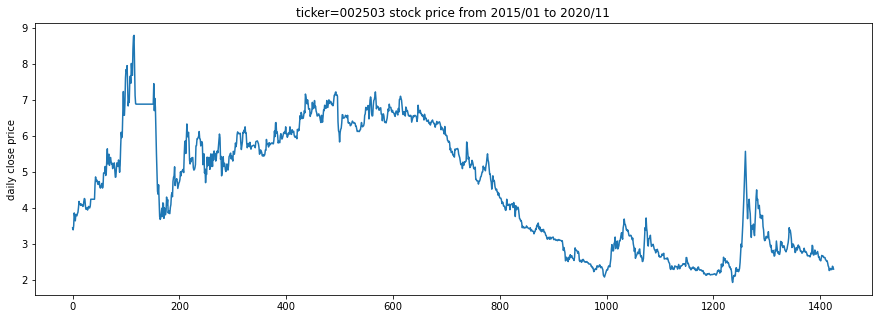

In [8]:
# visualize daily close data, lable y = column 1, ticker = 002503
close_price.plot(figsize=(15,5))
plt.ylabel('daily close price')
plt.title('ticker=002503 stock price from 2015/01 to 2020/11')
plt.show()

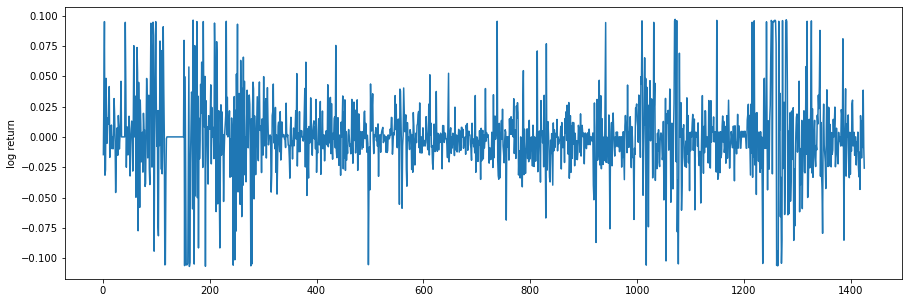

In [9]:
log_rtn = np.log(close_price).diff(1).dropna()
log_rtn.plot(figsize=(15,5))
plt.ylabel('log return')
plt.show()

## Test stationarity

In [10]:
test_stationarity(log_rtn) #p-value is small, it's stationary

Results of Dickey-Fuller Test:
Test Statistic                  -24.893409
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1423.000000
Critical Value (1%)              -3.434954
Critical Value (5%)              -2.863573
Critical Value (10%)             -2.567852
dtype: float64


## ACF & PACF

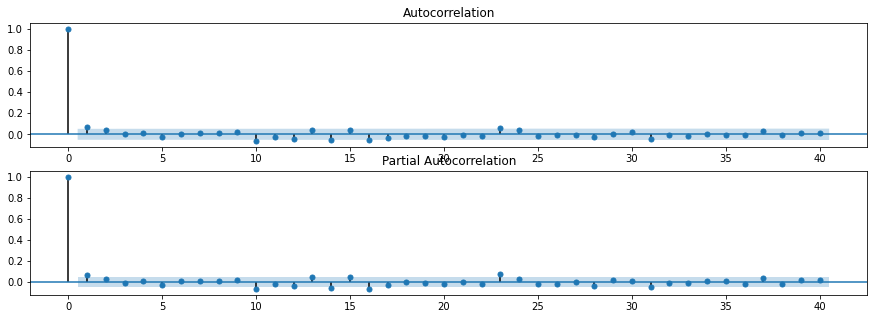

In [11]:
# acf & pacf for log return
import statsmodels.api as sm
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(log_rtn, lags=40, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(log_rtn, lags=40, ax=ax2)

## Distribution of log return

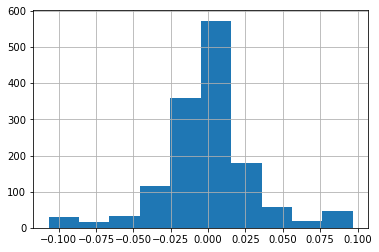

In [12]:
log_rtn.hist()
plt.show()

## Fit ARMA Model

In [13]:
import pandas as pd
import itertools
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima_model import ARIMA

p = range(6)
q = range(6)

combinations = list(itertools.product(p, q))
combinations = combinations[1:] # Drop (0,0)
def train_ARMA(param):
    p = param[0]
    q = param[1]
    model = ARIMA(log_rtn, order=(p,0,q))
    
    model_fit = model.fit(disp=0)
    
    ljung_p = sm.stats.acorr_ljungbox(model_fit.resid, lags=[12-p-q], return_df=True).values[0][1]
    aic = model_fit.aic
    return {'p': p, 'q': q, 'ljung_p': ljung_p, 'aic': aic}

results = pd.DataFrame(columns=['p', 'q', 'ljung_p', 'aic'])
for pq in combinations:
    results = results.append(train_ARMA(pq), ignore_index=True) 

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

,p,q,ljung_p,aic
28,4.0,5.0,0.709102,-5797.734488
14,2.0,3.0,0.949348,-5795.731396
34,5.0,5.0,0.178772,-5795.151167
13,2.0,2.0,0.744394,-5794.692706
15,2.0,4.0,0.965499,-5794.430235
25,4.0,2.0,0.985712,-5792.864528
21,3.0,4.0,0.966834,-5792.808776
5,1.0,0.0,0.474294,-5792.609129
32,5.0,3.0,0.903922,-5792.517151
0,0.0,1.0,0.437334,-5792.179429


## GARCH

In [14]:
mean = log_rtn.mean() # The mean closes to 0

### Check if GARCH's property

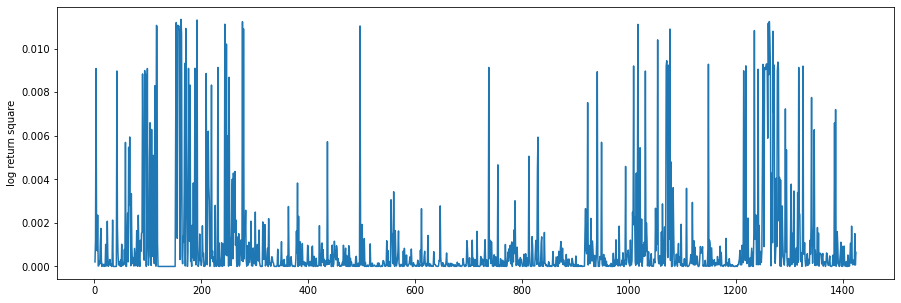

In [15]:
#log return square 
log_rtn_square = np.square(log_rtn - mean)
log_rtn_square.plot(figsize=(15,5))
plt.ylabel('log return square')
plt.show()

In [16]:
import statsmodels.api as sm

p_2 = sm.stats.acorr_ljungbox(log_rtn_square, lags=[40], return_df=True)['lb_pvalue'].values[0] # log return square is white noise if p < 0.05

print(f"P-value for squared log return: {p_2}")
if (p_2<0.05):
    print("Conclusion: Has ARCH's property in log rtn")
else:
    print("Conclusion: No ARCH's property in log rtn")

P-value for squared log return: 3.408651215462955e-304
Conclusion: Has ARCH's property in log rtn


In [17]:
from arch.univariate import arch_model
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(1,4)
q = range(1,4)

combinations = list(itertools.product(p, q))

def train_GARCH(param):
    p = param[0]
    q = param[1]
    model = arch_model(log_rtn, mean='constant', p=p, q=q)
    
    res = model.fit(update_freq=0)
    
    ljung_p = sm.stats.acorr_ljungbox(res.std_resid, lags=[12], return_df=True).values[0][1]
    aic = res.aic
    
    return {'p':p, 'q': q, 'alpha': res.params['alpha[1]'], 'beta': res.params['beta[1]'], 'ljung_p': ljung_p, 'aic': aic}

results = pd.DataFrame(columns=['p', 'q', 'alpha', 'beta', 'ljung_p', 'aic'])
for pq in combinations:
    results = results.append(train_GARCH(pq), ignore_index=True) 

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3123.7518223956017
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3123.8212536649166
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3120.509574864558
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3118.3592201207352
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 4
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3119.3721033546685
            Iterations: 6
            Function evaluati

,p,q,alpha,beta,ljung_p,aic
0,1.0,1.0,0.200000,0.700000,0.907046,-6239.503645
1,1.0,2.0,0.200000,0.350000,0.900829,-6237.642507
2,1.0,3.0,0.200000,0.233333,0.886722,-6229.019150
4,2.0,2.0,0.100000,0.350000,0.868628,-6226.744207
3,2.0,1.0,0.100009,0.699993,0.885098,-6226.718440
5,2.0,3.0,0.099999,0.233331,0.848578,-6220.871315
6,3.0,1.0,0.066667,0.700000,0.879460,-6216.071537
7,3.0,2.0,0.066703,0.349986,0.862128,-6214.831422
8,3.0,3.0,0.066667,0.233333,0.842956,-6210.059898


## EGARCH

In [18]:
from arch.univariate import arch_model
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(1,4)
q = range(1,4)

combinations = list(itertools.product(p, q))

def train_EGARCH(param):
    p = param[0]
    q = param[1]
    model = arch_model(log_rtn, vol='EGARCH', mean='constant', p=p, q=q, dist='t')
    
    res = model.fit(update_freq=0)
    
    ljung_p = sm.stats.acorr_ljungbox(res.std_resid, lags=[12], return_df=True).values[0][1]
    aic = res.aic
    return {'p':p, 'q': q, 'params': res.params, 'ljung_p': ljung_p, 'aic': aic}

results = pd.DataFrame(columns=['p', 'q', 'params', 'ljung_p', 'aic'])

for pq in combinations:
    results = results.append(train_EGARCH(pq), ignore_index=True) 

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3288.934352175669
            Iterations: 21
            Function evaluations: 160
            Gradient evaluations: 21
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3289.5018079177626
            Iterations: 31
            Function evaluations: 252
            Gradient evaluations: 31
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3289.5047589745172
            Iterations: 42
            Function evaluations: 377
            Gradient evaluations: 42
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3289.4680588326855
            Iterations: 27
            Function evaluations: 222
            Gradient evaluations: 27
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 7319.7409538984575
            Iterations: 7
            Functio

C:\Users\oscarko\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Optimization terminated successfully    (Exit mode 0)
            Current function value: 7997.633426768205
            Iterations: 40
            Function evaluations: 437
            Gradient evaluations: 36
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3289.526759771098
            Iterations: 55
            Function evaluations: 500
            Gradient evaluations: 55
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 8443.856286322622
            Iterations: 54
            Function evaluations: 622
            Gradient evaluations: 50


C:\Users\oscarko\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Iteration limit reached    (Exit mode 9)
            Current function value: 5849.318926434542
            Iterations: 100
            Function evaluations: 1276
            Gradient evaluations: 97


C:\Users\oscarko\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


,p,q,params,ljung_p,aic
0,1,1,mu -0.000779 omega -0.223040 alph...,0.943057,-6567.868704
1,1,2,mu -0.000778 omega -0.237098 alph...,0.935871,-6567.003616
3,2,1,mu -0.000780 omega -0.201212 alph...,0.935076,-6566.936118
6,3,1,mu -0.000776 omega -0.209488 alph...,0.936743,-6565.053520
2,1,3,mu -0.000779 omega -0.236487 alph...,0.935197,-6565.009518
8,3,3,mu -4.360238e-02 omega -6.260560e...,1.000000,11716.637853
4,2,2,mu 27.959223 omega -0.986299 al...,1.000000,14653.481908
